# [KUBIG] Basic Study CV Session week 3 Assignment 2: Vision Transformers

### 이 과제는 Vision 분야에서 유명한 데이터셋인 CIFAR10을 이용하여 Session때 소개드린 ViT(Vision Transformer)에 대해 학습하는 코드입니다.
이번 과제는 저번처럼 직접 채워넣을 내용이 많지는 않지만, ViT라는 큰 model이 어떻게 구성되고, class들을 어떻게 정의하는지, 또한 흐름이 어떻게 흘러가는지 충분히 알려면 꽤 자세하게 코드를 살펴봐야 한다고 생각합니다.
많은 분들이 colab을 기준으로 과제를 하시기 때문에 저번과 동일하게 .ipynb로 준비하였고, vscode로 작업하시는 분들은 따로 .py로 파일을 제공해드리겠습니다!
디버깅하시면서 질문은 slack DM과 카톡으로 언제든 환영합니다 :)

또한, CIFAR10 dataset을 알맞은 경로에 다운로드 받아야하고, checkpoint 또한 저장하게 설정되어 있으므로, drive 용량에 대해서 먼저 체크하시고 과제를 진행해주세요!

In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-1-0f4ea6d5afc8>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:
# Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!tar -xzvf "/content/drive/MyDrive/KUBIG/CV 분반/3주차/cifar-10-python.tar.gz" -C "/content/drive/MyDrive/KUBIG/CV 분반/3주차/"

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
# Set dataset path & checkpoint path
DATASET_PATH = '/content/drive/MyDrive/KUBIG/CV 분반/3주차/cifar-10-batches-py'
CHECKPOINT_PATH = '/content/drive/MyDrive/KUBIG/CV 분반/3주차/checkpoint'

100%|██████████| 170498071/170498071 [00:03<00:00, 52389045.64it/s]


Extracting /content/drive/MyDrive/KUBIG/CV 분반/3주차/cifar-10-batches-py/cifar-10-python.tar.gz to /content/drive/MyDrive/KUBIG/CV 분반/3주차/cifar-10-batches-py
Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


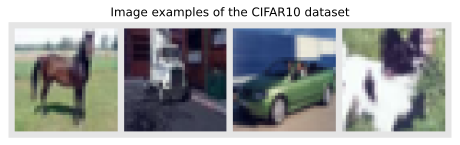

In [6]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Transformers for image classification

ViT는 Classification task에서 사용될 수 있습니다!
ViT의 가장 기본적인 아이디어는 이미지를 더 작은 patches의 sequence로 취급하는 것입니다.
전처리 단계에서 예를 들어 $48\times 48$ pixels의 이미지를 9개의 $16\times 16$으로 나눕니다. 여기에 positional encoding과 token을 추가함으로써 기존의 transformer structure에 vision data를 사용할 수 있게 됩니다.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial15/vit.gif?raw=1" width="600px"></center>

전처리부터 구현하겠습니다.
$N\times N$ 크기의 image는 $M\times M$ 크기의 $(N/M)^2$ 개의 patches로 나누어져야 합니다.
아래의 함수에서 x는 input image이고, 데이터의 형태는 주석으로 표현하였습니다.

#### 과제 1
"#"에 알맞은 문자를 채워넣으며, 데이터를 어떻게 전처리하는지 확인해보세요!

In [9]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

우리가 사용하는 CIFAR data에 대해 살펴보겠습니다.
$32\times 32$ 크기의 image에 대해, patch size를 4로 선택합니다. 따라서, $4\times 4$ 크기의 64개 patches로 이루어진 sequence data를 얻게 됩니다.
아래에서 이를 시각화하는 과정입니다.

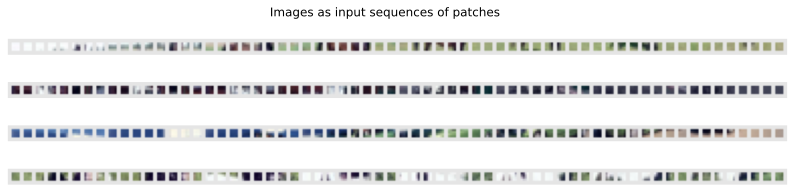

In [10]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

원본 이미지와 비교했을 때, 이제 patch squence에서 객체를 인식하기가 훨씬 더 어렵습니다. 그럼에도 불구하고, 이것이 image classification을 위해 transformer에 제공하는 input입니다.
ViT은 image를 이해하기 위해 patches를 어떻게 결합해야 하는지 스스로 학습해야 합니다. Sesion에서 말씀드렸듯이. CNN에서의 inductive bias, 즉 image가 pixel gred라는 개념은 이 input에서는 사라집니다.

여기서는 PyTorch 모듈 nn.MultiheadAttention을 사용할 것입니다. (시간이 되신다면, MultiHeadAttention을 pytorch documentation에 가셔서 이해해보시는 것이 모델을 이해하는데 큰 도움이 될 것 같습니다.)

또한, 2020년 Ruibin Xiong 등이 제안한 transformer의 Pre-Layer Normalization)버전을 사용합니다. 이 아이디어는 Layer Normalization을 residual blocks 사이가 아닌 residual block의 첫 번째 layer로 적용하는 것입니다. 이러한 재구성은 더 나은 gradient flow를 가능케합니다. 이에 대해서는 Session에서 시간상으로 소개드리지 못했지만, 현재는 이런 방식으로 많이 사용하기 때문에 코딩 과제에서 진행하도록 하겠습니다. 기존의 방법과 위에서 말씀드린 두 방법의 차이는 아래 그림을 참고하시면 더욱 잘 이해되실 것 같습니다.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial15/pre_layer_norm.svg?raw=1" width="400px"></center>

#### 과제 2
AttentionBlock의 forward함수를 위의 그림과 MultiheadAttention의 forward를 참고하여 작성해주세요!

In [11]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x) #hint : layer norm
        attn_output, _ = self.attn(inp_x, inp_x, inp_x)
        x = x + attn_output  #hint : attention
        x = self.layer_norm_2(x)
        x = x + self.linear(x)
        return x

Transformer encoder 외에도, 다음과 같은 모듈이 필요합니다:

* input patch를 더 큰 크기의 feature vector로 매핑하는 linear projection layer입니다. 이것은 각 $M\times M$ 패치를 독립적으로 입력으로 취하는 간단한 linear layer에 의해 구현됩니다.

* input sequence에 추가되는 classification token입니다. 분류 예측을 결정하기 위해 classification token (CLS token으로 줄여서 표현)의 출력 feature vector를 사용할 것입니다.

* Transformer에 의해 처리되기 전에 tokens에 추가되는 학습 가능한 positional encodings입니다. 이것들은 위치에 따른 정보를 학습하고 set을 sequence로 변환하는 데 필요합니다. 우리는 보통 고정된 해상도로 작업하기 때문에, sine과 cosine 함수의 패턴 대신 positional encodings을 학습할 수 있습니다.

* CLS token의 출력 feature vector를 취해 분류 예측으로 매핑하는 MLP head입니다. 이것은 보통 작은 feed-forward network나 심지어 단일 linear layer로 구현됩니다.

#### 과제 3
initialize와 ViT의 structure를 고려하여 forward에 빈칸을 채워주세요!

In [12]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size) # hint : input to patch (function 사용!) -> patch 단위로 나누어야 함
        B, T, _ = x.shape
        x = self.input_layer(x) # hint : linear -> linear projection

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = x + cls_token # input = x / token = class token
        x = x + self.pos_embedding[:, :T, :] # hint : ViT에는 꼭 있어야하는..! -> positional embedding (sequence data)

        # Apply Transforrmer
        x = self.dropout(x) # hint : 과적합 방지
        x = x.transpose(0, 1)
        x = self.transformer(x) # hint : model
        # x = x.transpose(0, 1)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

마지막으로, 이제까지 구현한 것들을 모든 것을 PyTorch Lightning Module에 넣을 수 있습니다. optimizer로는 weight decay 구현이 수정된 Adam인 torch.optim.AdamW를 사용합니다.

In [13]:
class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

Session때 말씀드렸듯이 일반적으로 Vision Transformers는 ImageNet과 같은 대규모 이미지 분류 벤치마크에 적용되어 그들의 전체 잠재력을 발휘합니다.
그렇다면 Vision Transformer가 CIFAR10과 같은 클래식하고 작은 벤치마크에서도 성공할 수 있을까요?!
이를 알아보기 위해, CIFAR10 데이터셋에서 처음부터 Vision Transformer를 훈련시킵니다 :)

In [14]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    pl.seed_everything(42)
    model = ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # 훈련 후 가장 좋은 체크포인트 불러오기

    # Test
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

구현에서 볼 수 있듯이, 우리는 설정해야 할 몇 가지 hyperparameters가 있습니다.

먼저 patch size를 고려해 봅시다. patch를 작게 만들수록 Transformer에 대한 input sequence 길이가 길어집니다. 일반적으로 이는 Transformer가 더 복잡한 함수를 모델링할 수 있게 하지만, attention layer에서의 제곱 메모리 사용으로 인해 더 긴 계산 시간이 필요합니다. 또한, 작은 패치는 Transformer가 어떤 패치가 가까이 있는지, 어느 것이 멀리 있는지를 학습해야 하므로 작업을 더 어렵게 만들 수 있습니다. 저는 실험적으로 4를 선택했습니다.
이 부분은 청수님께서 Session에서 질문하셨던 부분이었죠! 실험적으로도 테스트해보고 생각해보시면 좋을 것 같습니다.

다음으로, **embedding과 hidden dimensionality는 MLP에서와 마찬가지로 Transformer에 영향**을 미칩니다. 크기가 클수록 모델이 더 복잡해지고 훈련하는 데 더 오래 걸립니다. 그러나 Transformers에서는 한 가지 더 고려해야 할 사항이 있습니다: **Multi-Head Attention layer에서의 query-key 크기**입니다. 각 key는 embed_dim/num_heads의 feature dimension을 가집니다. input sequence 길이가 64인 것을 고려하면, key vectors에 대한 최소 합리적인 크기는 16 또는 32입니다. 낮은 차원은 가능한 attention map을 너무 제한할 수 있습니다. 이에 Transformer에 8개 이상의 head가 필요하지 않다고 판단하였으며, 따라서 256의 embedding dimensionality를 선택합니다. feed-forward network에서의 hidden dimensionality는 일반적으로 embedding dimensionality보다 2-4배 크므로, 이에 512를 선택합니다.

마지막으로, Transformers에 대한 learning rate는 일반적으로 상대적으로 작으며, 논문에서 흔히 사용되는 값은 3e-5입니다. 그러나 지금은 더 작은 데이터셋으로 작업하고 잠재적으로 더 쉬운 작업을 가지고 있기 때문에, 문제 없이 learning rate를 3e-4정도로 높일 수 있습니다. overfit을 줄이기 위해 0.2의 dropout 값을 사용합니다.

아래 값들을 변경하여 hyperparameters를 변경하면서 직접 성능을 올려보세요! 하이퍼파라미터 튜닝 또한 제가 위에 적어놓은 제 생각처럼 고민하시면서 튜닝을 하시면 충분히 모델의 이해도를 높이는데 도움이 될 것이라고 생각합니다.

또한, 제 생각과 실험이 최선은 아니니 더 좋은 결과를 내고 분석해주시는 것을 기대하겠습니다!

In [15]:
model, results = train_model(model_kwargs={
                                'embed_dim': 256,
                                'hidden_dim': 512,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 4,
                                'num_channels': 3,
                                'num_patches': 64,
                                'num_classes': 10,
                                'dropout': 0.2
                            },
                            lr=3.5e-4)
print("ViT results", results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=180` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.7701999545097351, 'val': 0.7797999978065491}
